In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_price = pd.read_parquet("../data/poc/price.parquet")
df_item = pd.read_parquet("../data/poc/item.parquet")

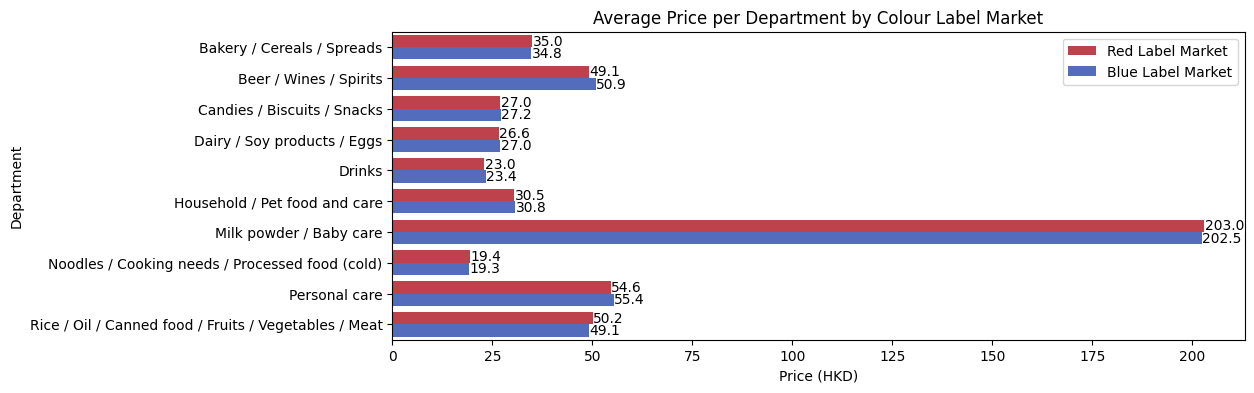

In [3]:
smkt_list = ["WELLCOME", "PARKNSHOP"]

sku_smkt = df_price.groupby("sku", as_index=False)["smkt"].unique()
sku_smkt["flag"] = sku_smkt["smkt"].apply(
    lambda x: all(smkt in x for smkt in smkt_list)
)

sku_list = sku_smkt.query("flag")["sku"]

col = ["sku", "dept_en"]
sku_dept = df_item[col].copy()

smkt_price = df_price.query("smkt in @smkt_list and sku in @sku_list") \
    .groupby(["sku", "smkt"], as_index=False)["price"].mean()
smkt_price = smkt_price.merge(sku_dept, how="left", on="sku")
smkt_price = smkt_price.groupby(["smkt", "dept_en"], as_index=False) \
    ["price"].mean()

smkt_order = [
    "WELLCOME", "PARKNSHOP"]

smkt_price["smkt"] = smkt_price["smkt"].astype("category")
smkt_price["smkt"] = smkt_price["smkt"].cat \
    .set_categories(smkt_order, ordered=True)


colors = {
    "WELLCOME": "#d22d3a",
    "PARKNSHOP": "#4164ce",
}

plt.figure(figsize=(11, 4))
bar_plot = sns.barplot(
    x="price", y="dept_en",
    hue="smkt", palette=colors,
    data=smkt_price,
)

for p in bar_plot.patches:
    width = p.get_width()
    plt.text(
        width + 0.1, p.get_y() + p.get_height() / 2,
        "{:1.1f}".format(width), ha="left", va="center"
    )

plt.title("Average Price per Department by Colour Label Market")
plt.xlabel("Price (HKD)")
plt.ylabel("Department")
handles, labels = bar_plot.get_legend_handles_labels()
bar_plot.legend(handles, ["Red Label Market", "Blue Label Market"])

plt.show()

In [4]:
sku_ts = df_price.groupby(["sku", "date"], as_index=False) \
    ["price"].min()

col = [
    "sku", "freq", "price_avg", "price_std",
    "price_q0", "price_q1", "price_q2", "price_q3", "price_q4",
]
sku_stats = sku_ts.groupby("sku", as_index=False) \
    ["price"].describe()
sku_stats.columns = col

sku_tdy = df_price.query("date == '20240101'").copy()

smkt_order = [
    "WELLCOME", "PARKNSHOP", "JASONS", "AEON",
    "MANNINGS", "WATSONS", "DCHFOOD",
]
smkt_misc = [
    smkt for smkt in sku_tdy["smkt"].unique()
    if smkt not in smkt_order
]
smkt_order += smkt_misc

sku_tdy["smkt"] = sku_tdy["smkt"].astype("category")
sku_tdy["smkt"] = sku_tdy["smkt"].cat \
    .set_categories(smkt_order, ordered=True)

sku_tdy.sort_values(by=["price", "smkt"], inplace=True)
sku_tdy.drop_duplicates(subset="sku", ignore_index=True, inplace=True)

sku_tdy = sku_tdy.merge(sku_stats, how="left", on="sku")
sku_alert = sku_tdy.query("price < price_q1")
print(f"Total of {len(sku_alert):,} items to be notified")

Total of 194 items to be notified


In [5]:
sku = "P000000014"

sku_info = df_item.query("sku == @sku").to_dict("records")[0]
sku_price = sku_alert.query("sku == @sku").to_dict("records")[0]

print(f"Product: {sku_info['brand_en']}; {sku_info['name_en']}")
print(f"Unit Price: ${sku_price['price']:.2f} ({sku_price['promo_en']})")
print(f"Supermarket: {sku_price['smkt']}")
print(
    f"MA({sku_price['freq']:.0f}) Statistics: "
    f"avg. ${sku_price['price_avg']:.2f} ± {sku_price['price_std']:.2f} | "
    f"min. ${sku_price['price_q0']:.2f} | "
    f"max. ${sku_price['price_q4']:.2f}"
)

Product: Nissin; Demae Ramen Instant Noodle - Five Spice Beef Flavour 100g
Unit Price: $3.09 (buy 10 to save $18.10)
Supermarket: PARKNSHOP
MA(60) Statistics: avg. $3.42 ± 0.19 | min. $3.09 | max. $3.56


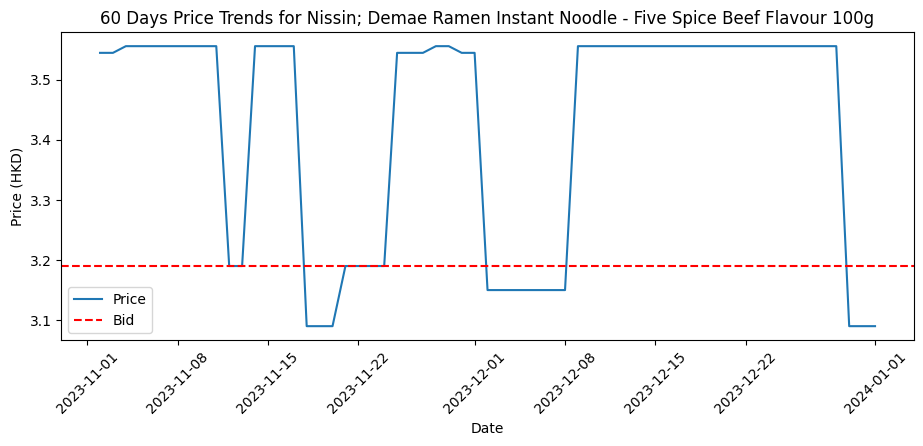

In [6]:
sku_data = sku_ts.query("sku == @sku").copy()
sku_data["date"] = pd.to_datetime(sku_data["date"], format="%Y%m%d")

sku_q1 = sku_price["price_q1"]


plt.figure(figsize=(11,4))
plt.plot(sku_data["date"], sku_data["price"], label="Price")
plt.axhline(y=sku_q1, color="r", linestyle="--", label="Bid")

plt.title(f"{sku_price['freq']:.0f} Days Price Trends for {sku_info['brand_en']}; {sku_info['name_en']}")
plt.xlabel("Date")
plt.ylabel("Price (HKD)")
plt.legend()
plt.xticks(rotation=45)

plt.show()